In [7]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA
import numpy as np
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import jaccard_score
import seaborn as sn
from tabulate import tabulate
from xgboost import XGBClassifier
from ta import add_all_ta_features
from sklearn.feature_selection import RFE

In [23]:
WINDOW = 16 # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
INTERVAL = '1y'     # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
symbol = 'AAPL'      # Symbol of the desired stock
ROWS_TO_PREDICT = 64
# one day 16 rows of data

In [24]:
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = symbol,


        period = INTERVAL,

        interval = FETCH_INTERVAL,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        # auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )
data
data.to_csv(f'../data/preprocess/APPLE_{ datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv', index=False)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: 1h data not available for startTime=1522003950 and endTime=1616611950. The requested range must be within the last 730 days.


In [25]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
Date,,,,,,


<AxesSubplot:xlabel='Date'>

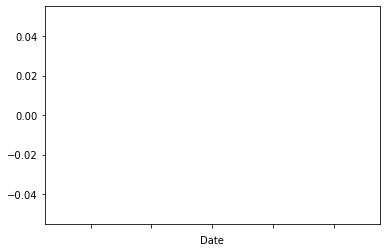

In [26]:
data['close'].plot()

In [27]:
data['close_pct'] = data['close'].pct_change();
data.head()

,open,high,low,close,Adj Close,volume,close_pct
Date,,,,,,,


In [28]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """


    data = add_all_ta_features(
    data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    # del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)

IndexError: iloc cannot enlarge its target object

In [30]:
data

,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt
Date,,,,,,,,,,,,,,,


In [31]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi',
       'volume_em', 'volume_sma_em', 'volume_vpt'],
      dtype='object')

In [32]:
def create_class_column(row):
    if row['close_shift']-row['close'] > 1.5:
        return 1
    if row['close_shift'] -row['close']< -1.5:
        return -1
    else:
        return 0

In [33]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,Adj Close,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,close_shift
Date,,,,,,,,,,,,,,,,


In [34]:
data['class_column'] = data.apply(create_class_column, axis=1)
data

ValueError: Wrong number of items passed 16, placement implies 1

In [35]:
# Class divide
data['class_column'].value_counts()

KeyError: 'class_column'

In [36]:
del (data['close'])
del (data['close_shift'])
data = data.dropna()
train_set = data.iloc[:-ROWS_TO_PREDICT]
train_set = train_set.iloc[:-WINDOW] # optional drop last n rows (avoid of data leak)
test_set =data.iloc[-ROWS_TO_PREDICT:]

In [37]:
data['class_column'].value_counts()

KeyError: 'class_column'

In [755]:
train_set

,volume,close_pct,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,class_column
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-03-24 05:00:00-04:00,0,0.001754,0.000000e+00,0,0.000000,0.000000,50.000000,0.000000,0.000000,0.0,...,0.000000,58.493475,0.000000,0.000000,0.000000,0.000000,0.175371,0.175217,0.175371,1
2020-03-24 06:00:00-04:00,0,0.011486,0.000000e+00,0,0.000000,0.000000,50.000000,0.000000,0.000000,0.0,...,0.000000,58.811505,0.000000,0.000000,0.000000,0.000000,1.148591,1.142045,1.325976,1
2020-03-24 07:00:00-04:00,0,-0.015450,0.000000e+00,0,0.000000,0.000000,50.000000,0.000000,0.000000,0.0,...,0.000000,58.591523,0.000000,0.000000,0.000000,0.000000,-1.545021,-1.557081,-0.239531,1
2020-03-24 08:00:00-04:00,0,-0.002272,0.000000e+00,0,0.000000,0.000000,50.000000,0.000000,0.000000,-0.0,...,0.000000,58.413600,0.000000,0.000000,0.000000,0.000000,-0.227243,-0.227502,-0.466230,1
2020-03-24 09:00:00-04:00,0,0.012334,0.000000e+00,0,0.000000,0.000000,50.000000,0.000000,0.000000,0.0,...,0.017667,58.610294,0.000000,0.000000,0.000000,0.000000,1.233391,1.225846,0.761410,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-17 04:00:00-04:00,0,-0.002635,7.269030e+08,-160151677,-0.014676,21306.977788,63.864598,2.686727,-0.615946,-0.0,...,0.776356,125.612525,-0.865148,-19.422475,0.969298,-20.391773,-0.263515,-0.263863,113.696052,0
2021-03-17 05:00:00-04:00,0,0.002082,7.269030e+08,-160151677,-0.014676,18263.123818,63.864598,2.686727,-0.615946,0.0,...,0.549786,125.605208,-0.988849,-26.364539,-4.497470,-21.867069,0.208167,0.207950,114.140896,0
2021-03-17 06:00:00-04:00,0,-0.003196,7.269030e+08,-160151677,-0.014676,15654.106130,63.864598,2.686727,-0.615946,0.0,...,1.091875,125.534846,-1.573900,-32.708517,-10.139679,-22.568838,-0.319591,-0.320103,113.456521,0


In [756]:
y = data['class_column']
features = [x for x in data.columns if x not in ['class_column']]
x = data[features]
scaler = MinMaxScaler()
# x = pd.DataFrame(scaler.fit_transform(x.values), columns=x.columns, index=x.index)
x_train= x.iloc[:-ROWS_TO_PREDICT]
y_train= y.iloc[:-ROWS_TO_PREDICT]
x_test =x.iloc[-ROWS_TO_PREDICT:]
y_test=y.iloc[-ROWS_TO_PREDICT:]

In [757]:
classifiers = dict()

classifiers['DecisionTreeClassifier 1'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='best')
classifiers['DecisionTreeClassifier 2'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='gini',splitter='random')
classifiers['DecisionTreeClassifier 3'] = DecisionTreeClassifier(max_depth=10, random_state=0,criterion='entropy',splitter='best')
classifiers['RandomForestClassifier 4'] = RandomForestClassifier(n_estimators=1000, max_depth=3, random_state=0,criterion='gini', n_jobs = -1)
classifiers['RandomForestClassifier 5'] = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0,criterion='entropy', n_jobs = -1)
classifiers['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)

In [758]:
def print_conf_matrix(test_y, predict, name):
    matrix = confusion_matrix(test_y, predict,  labels=[-1, 0, 1])
    print(matrix)
    ax= plt.subplot()
    sn.heatmap(matrix, annot=True, ax = ax) #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels', color='white')
    ax.set_ylabel('True labels', color='white')
    ax.set_title(f'Confusion Matrix for {name}' , color='white')
    ax.xaxis.set_ticklabels(['-1','0', '1'], color='white')
    ax.yaxis.set_ticklabels(['-1','0', '1'], color='white')
    plt.show()

def train_model(model,train_x, train_y):
    model.fit(train_x, train_y)

In [759]:
predictions= dict()
score = dict()
for k,v in classifiers.items():
    print("Calculate: ", k)
    train_model(v,x_train,y_train)
    predictions[k] = v.predict(x_test)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))


Calculate:  DecisionTreeClassifier 1
Score:  0.390625
Calculate:  DecisionTreeClassifier 2
Score:  0.453125
Calculate:  DecisionTreeClassifier 3
Score:  0.8125
Calculate:  RandomForestClassifier 4
Score:  0.703125
Calculate:  RandomForestClassifier 5
Score:  0.703125
Calculate:  GradientBoostingClassifier 1
Score:  0.65625
Calculate:  GradientBoostingClassifier 2
Score:  0.65625
+----+------------------------------+------------+
|    | Classifier type              |   Accuracy |
|----+------------------------------+------------|
|  0 | DecisionTreeClassifier 1     |   0.390625 |
|  1 | DecisionTreeClassifier 2     |   0.453125 |
|  2 | DecisionTreeClassifier 3     |   0.8125   |
|  3 | RandomForestClassifier 4     |   0.703125 |
|  4 | RandomForestClassifier 5     |   0.703125 |
|  5 | GradientBoostingClassifier 1 |   0.65625  |
|  6 | GradientBoostingClassifier 2 |   0.65625  |
+----+------------------------------+------------+


In [760]:
filename_to_export = f'../data/results/{symbol}_1_{WINDOW}_{ROWS_TO_PREDICT}_{ datetime.now().strftime("%d_%m_%Y %H_%M_%S")}.csv'
score_df.to_csv(filename_to_export, index=False)

In [761]:
rfe = RFE(classifiers['RandomForestClassifier 5'],10)
fited = rfe.fit(x_train, y_train)
rfe

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


RFE(estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                     n_jobs=-1, random_state=0),
    n_features_to_select=10)

In [762]:
names = x.columns
columns=[]
for i in range(len(fited.support_)):
    if fited.support_[i]:
        columns.append(names[i])

print("Columns with predictive power:", columns )

Columns with predictive power: ['volume_nvi', 'volatility_kcc', 'volatility_kch', 'volatility_dcw', 'trend_sma_fast', 'trend_ema_fast', 'trend_ichimoku_b', 'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'momentum_kama']


In [763]:
x_test_cropped = x_test[columns]
x_train_cropped = x_train[columns]
x_train_cropped

,volume_nvi,volatility_kcc,volatility_kch,volatility_dcw,trend_sma_fast,trend_ema_fast,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,momentum_kama
Datetime,,,,,,,,,,
2020-03-24 05:00:00-04:00,1000.000000,58.393333,59.149583,1.559862,58.498750,58.463269,58.381250,106.648515,106.682080,58.493475
2020-03-24 06:00:00-04:00,1000.000000,58.607222,59.438889,2.566394,58.740000,58.580074,58.678750,106.648515,106.682080,58.811505
2020-03-24 07:00:00-04:00,1000.000000,58.606042,59.604792,2.686252,58.631875,58.538140,58.712500,106.648515,106.682080,58.591523
2020-03-24 08:00:00-04:00,1000.000000,58.525000,59.486500,2.891161,58.540500,58.482272,58.653750,106.648515,106.682080,58.413600
2020-03-24 09:00:00-04:00,1000.000000,58.537779,59.499446,2.888266,58.599171,58.545388,58.653750,106.648515,106.682080,58.610294
...,...,...,...,...,...,...,...,...,...,...
2021-03-17 19:00:00-04:00,1250.486279,124.057350,124.912871,6.505638,124.046358,124.448902,121.377501,123.491251,120.296251,123.695894
2021-03-18 04:00:00-04:00,1250.486279,124.139424,124.986464,2.853608,124.039692,124.364455,121.508866,123.556933,120.296251,123.703650
2021-03-18 05:00:00-04:00,1250.486279,124.211257,125.095297,2.856090,124.031358,124.209924,121.508866,123.556933,120.296251,123.697893


In [764]:
classifiers_boosted = dict()
classifiers_boosted['GradientBoostingClassifier 1'] = GradientBoostingClassifier(n_estimators=100,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.1)
classifiers_boosted['GradientBoostingClassifier 2'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=3, learning_rate=0.3)
classifiers_boosted['GradientBoostingClassifier 3'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.5)
classifiers_boosted['GradientBoostingClassifier 4'] = GradientBoostingClassifier(n_estimators=1000,random_state=0,criterion='friedman_mse',max_depth=2, learning_rate=0.8)

In [765]:
predictions= dict()
score = dict()
for k,v in classifiers_boosted.items():
    print("Calculate: ", k)
    train_model(v,x_train_cropped,y_train)
    predictions[k] = v.predict(x_test_cropped)
    score[k] = accuracy_score(y_test.values, predictions[k])
    print('Score: ',  score[k] )
    # print_conf_matrix(test_y, predictions[k], k)

headers = ["Classifier type", "Accuracy"]
score_df = pd.DataFrame(score.items(), columns=headers)
print(tabulate(score_df, headers, tablefmt="psql"))

Calculate:  GradientBoostingClassifier 1
Score:  0.625
Calculate:  GradientBoostingClassifier 2
Score:  0.609375
Calculate:  GradientBoostingClassifier 3
Score:  0.5
Calculate:  GradientBoostingClassifier 4
Score:  0.546875
+----+------------------------------+------------+
|    | Classifier type              |   Accuracy |
|----+------------------------------+------------|
|  0 | GradientBoostingClassifier 1 |   0.625    |
|  1 | GradientBoostingClassifier 2 |   0.609375 |
|  2 | GradientBoostingClassifier 3 |   0.5      |
|  3 | GradientBoostingClassifier 4 |   0.546875 |
+----+------------------------------+------------+


In [766]:
score_df.to_csv(filename_to_export,mode='a', index=False)